In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Índice

1. Objetivo
2. Datos de interés
3. Tipos de datos
4. Primeros análisis
5. Eliminación de missings
6. Vectorización
7. Revisión de datos
8. Modelización

## 1. Objetivo:

Analizar los datos de distintos corredores de maratón para poder infrerir una predicción con machine learning.

## 2. Datos de interés
Guardamos el  archivo como data frame en pandas y observamos qué datos podrían ser de interés.

In [3]:
datos_maraton= pd.read_csv('MarathonData.csv')
datos_maraton.head(5)

,id,Marathon,Name,Category,km4week,sp4week,CrossTraining,Wall21,MarathonTime,CATEGORY
0,1,Prague17,Blair MORGAN,MAM,132.8,14.434783,NaN,1.16,2.37,A
1,2,Prague17,Robert Heczko,MAM,68.6,13.674419,NaN,1.23,2.59,A
2,3,Prague17,Michon Jerome,MAM,82.7,13.520436,NaN,1.30,2.66,A
3,4,Prague17,Daniel Or lek,M45,137.5,12.258544,NaN,1.32,2.68,A
4,5,Prague17,Luk ? Mr zek,MAM,84.6,13.945055,NaN,1.36,2.74,A


Vemos que no necesitarmemos los nombres propios, ni el identificador de serie, es por eso que eliminamos las columnas.

In [4]:
datos_maraton= datos_maraton.drop(['Marathon','Name','CATEGORY','id'],axis=1)


In [5]:
datos_maraton

,Category,km4week,sp4week,CrossTraining,Wall21,MarathonTime
0,MAM,132.8,14.434783,NaN,1.16,2.37
1,MAM,68.6,13.674419,NaN,1.23,2.59
2,MAM,82.7,13.520436,NaN,1.30,2.66
3,M45,137.5,12.258544,NaN,1.32,2.68
4,MAM,84.6,13.945055,NaN,1.36,2.74
...,...,...,...,...,...,...
82,M55,50.0,10.830325,NaN,2.02,3.93
83,M40,33.6,10.130653,ciclista 3h,1.94,3.93
84,M40,55.4,11.043189,NaN,1.94,3.94
85,M45,33.2,11.066667,NaN,2.05,3.95


## 3. Tipos de datos

Siempre es importante ver que todo vaya en orden, así que tras limpiar las cosas más innecesarias vamos a mirar los tipos de datos.

In [6]:
datos_maraton.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 6 columns):
Category         81 non-null object
km4week          87 non-null float64
sp4week          87 non-null float64
CrossTraining    13 non-null object
Wall21           87 non-null object
MarathonTime     87 non-null float64
dtypes: float64(3), object(3)
memory usage: 4.2+ KB


Primera alerta, vemos como tenemos que en la columna Wall21 hay un fallo de type, tendría que ser un float y lo vemos como object, así que tenemos que arreglar esto.

In [7]:
datos_maraton['Wall21']= pd.to_numeric(datos_maraton['Wall21'],errors='coerce') #Si hubiese un fallo devuelve NaN
datos_maraton.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 6 columns):
Category         81 non-null object
km4week          87 non-null float64
sp4week          87 non-null float64
CrossTraining    13 non-null object
Wall21           81 non-null float64
MarathonTime     87 non-null float64
dtypes: float64(4), object(2)
memory usage: 4.2+ KB


Podemos observar como ahora sí tenemos Wall21 como foat64, con lo que podemos hacer los primeros histogramas y correlaciones. Usaré pandas_profiling para hacer el escaneo general

## 4. Primer análisis

In [8]:
import pandas_profiling as pp

In [9]:
pp.ProfileReport(datos_maraton)

C:\Users\Francisco.LAPTOP-KS99SO8L\Anaconda3\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,6
Number of observations,87
Total Missing (%),16.5%
Total size in memory,4.2 KiB
Average record size in memory,49.5 B
Numeric,3
Categorical,2
Boolean,0
Date,0
Text (Unique),0
Rejected,1


### Conclusiones

Como siempre ocurre con cualquier serie de datos debemos hacer algo con los datos nulos, en este caso tenemos en las columnas Category, CrossTraining y Wall21. Así pues, debemos tomar decisión.

Para el caso de CrossTraining haremos una vectorización de los diferentes objetos que haya, y el valor 0 será el seleccionado para la pérdida, y lo tomaremos como que no lo realiza. 

En el caso de la categoría podríamos sustituir por MAM, pero decido eliminarlos para mayor comodidad, y así tener los tres tipos de ejemplo.

Por último para Wall21, y a expensas de hacer algo de trampas, voy a hacer una regresión lineal con MarathonTime  y rellenar esos 6 datos, puesto que el entrenamniento no solo es con Wall21 sino con otros muchos datos.

## 5. Eliminación de missings

Primero arreglemos Wll21. Para la regresión lineal utilizaré la función curve_fit, pero antes vamos a echar un vistazo a los datos. Cabe mencionar que esto es una actividad de aprendizaje, para hacerlo más rápido y mejor usando df.interpolate ya estaría. Pero con este método podríamos cambiar la interpolación por funciones no lineales.

Text(0, 0.5, 'Wall 21')

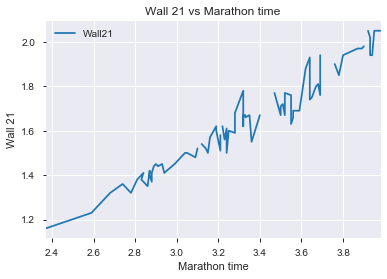

In [10]:

%matplotlib inline
datos_maraton.plot(x='MarathonTime', y= 'Wall21', kind='line')
plt.title('Wall 21 vs Marathon time')
plt.xlabel('Marathon time')
plt.ylabel('Wall 21')




Probemos ahora a hacer la regresón lineal a ver si nos deja con los missings en ella.

In [11]:
from scipy.optimize import curve_fit

def modelo(x,a_0,a_1):
    f= a_0 + x*a_1
    return f

popt, pcov = curve_fit(modelo, datos_maraton['MarathonTime'], datos_maraton['Wall21'], p0=[0,0])

error_constantes= np.sqrt(np.diag(pcov))

valor_constantes=popt



ValueError: array must not contain infs or NaNs

Como me imaginaba, no somos capaces de sortear los NaNs, así que deberemos quitarlos para la regresión, pero no modificamos los datos generales.

In [12]:
datos_regresion= datos_maraton[['Wall21','MarathonTime']].dropna(inplace=False) #Datos usados para la regresión lineal.

In [13]:
datos_regresion.isna().sum()

Wall21          0
MarathonTime    0
dtype: int64

Nos acabamos de cerciorar de que no temenos missings en nuestro nuevo y pequeño dataset, volvamos a intentar el curve_fit.

In [14]:
popt, pcov = curve_fit(modelo, datos_regresion['MarathonTime'], datos_regresion['Wall21'], p0=[0,0])

error_constantes= np.sqrt(np.diag(pcov))

valor_constantes=popt

Text(0, 0.5, 'Wall 21')

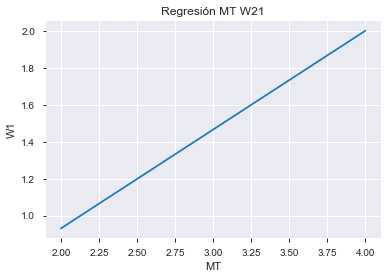

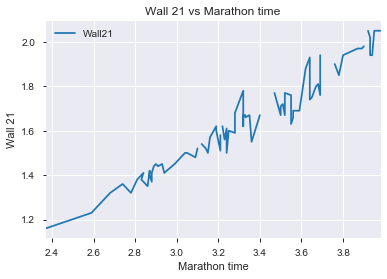

In [15]:

x=np.linspace(2,4,100)

#Valor_constantes y polyval no se entienden bien, tienen el orden invertido de las constantes, debemos girarlo.
#En una versión más nueva tenemos array.flip, en este caso debo hacerlo a ''mano''

valor_constantes= np.array([valor_constantes[1],valor_constantes[0]]) #Debería actualizarme  o bien hacerlo general :V

y=np.polyval(valor_constantes,x)

plt.plot(x,y)
plt.title('Regresión MT W21')
plt.xlabel('MT')
plt.ylabel('W1')

datos_maraton.plot(x='MarathonTime', y= 'Wall21', kind='line')
plt.title('Wall 21 vs Marathon time')
plt.xlabel('Marathon time')
plt.ylabel('Wall 21')

Ahora que ya tenemos la regresión lineal solo resta sustituir los valores missings por sus valores correspondientes, es por ello que buscamos los índices de los mismos.

In [16]:
#Debemos encontrar el índice de los missings para poder sustituirlos por los datos de la regresión

lista_na_w21=datos_maraton['Wall21'].isna()

#Aquí tendríamos un sistema 'fácil' de identificación de Nans
for i, na in enumerate(lista_na_w21):
    if na:
        print(i)

25
34
51
53
73
80


In [17]:
indices_nan = [i for i,na in enumerate(datos_maraton['Wall21'].isna()) if na]

Ahora que tenemos el índice de los missings vamos a ver qué marathone time tenían

In [18]:
datos_maraton.iloc[indices_nan]

,Category,km4week,sp4week,CrossTraining,Wall21,MarathonTime
25,NaN,23.8,13.471698,ciclista 5h,NaN,3.11
34,NaN,112.2,11.276382,NaN,NaN,3.22
51,NaN,70.7,12.662687,NaN,NaN,3.45
53,NaN,51.1,11.230769,NaN,NaN,3.47
73,NaN,53.6,12.711462,NaN,NaN,3.75
80,NaN,38.1,11.043478,NaN,NaN,3.90


Ya tenemos estos pocos datos que tenemos que corregir.

In [19]:
indices_nan= np.array(indices_nan)

#Intercambiamos los valores por los de nuestro modelo lineal

w21_missings=list(modelo(datos_maraton.loc[indices_nan,'MarathonTime'], a_0=valor_constantes[1],a_1=valor_constantes[0]))

print(w21_missings)

[1.5250857563587643, 1.584037851082489, 1.7073013218684585, 1.7180198845454995, 1.8680797620240708, 1.9484689821018772]


In [20]:
for i, na in enumerate(indices_nan):
    datos_maraton.loc[na,'Wall21']=w21_missings[i]

In [21]:
datos_maraton['Wall21'].isna().sum()  #Nos aseguramos que hemos retirado los missings de Wall21 correctamente

0

Ahora que ya hemos solucionado los missings Vamos a ver que todo esté correcto

Text(0, 0.5, 'Wall 21')

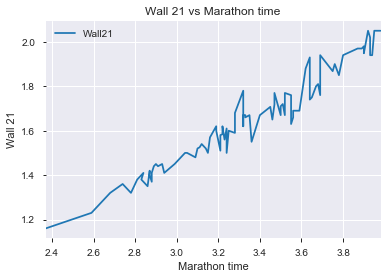

In [22]:
datos_maraton.plot(x='MarathonTime', y= 'Wall21', kind='line')
plt.title('Wall 21 vs Marathon time')
plt.xlabel('Marathon time')
plt.ylabel('Wall 21')

### El resto de missings

Una vez finalizado con Wall21 podemos terminar de eliminar el resto de missings

In [23]:
datos_maraton['CrossTraining']= datos_maraton['CrossTraining'].fillna(0)

In [24]:
datos_maraton = datos_maraton.dropna(inplace=False)

In [25]:
datos_maraton.isna().sum()

Category         0
km4week          0
sp4week          0
CrossTraining    0
Wall21           0
MarathonTime     0
dtype: int64

Ya no quedan missings ni fallos

## 6. Vectorización

Como siempre, deberemos ver cuantos datos diferentes tenemos en cada columna, comenzaremos con Crosstraining

In [30]:
key_list=datos_maraton.CrossTraining.unique()  #Tomamos todos los posibles objetos


In [33]:
# 0; 0, 'ciclista 1h': 1, 'ciclista 4h': 2, 'ciclista 13h': 3, 'ciclista 3h': 4, 'ciclista 5h': 5

#Los reemplazamos en el df

for i, key in enumerate(key_list):    
    datos_maraton.replace(to_replace=key, value=i, inplace= True)



Revisamos que se hayan cambiado de manera correcta

In [34]:
datos_maraton

,Category,km4week,sp4week,CrossTraining,Wall21,MarathonTime
0,MAM,132.8,14.434783,0,1.16,2.37
1,MAM,68.6,13.674419,0,1.23,2.59
2,MAM,82.7,13.520436,0,1.30,2.66
3,M45,137.5,12.258544,0,1.32,2.68
4,MAM,84.6,13.945055,0,1.36,2.74
...,...,...,...,...,...,...
82,M55,50.0,10.830325,0,2.02,3.93
83,M40,33.6,10.130653,4,1.94,3.93
84,M40,55.4,11.043189,0,1.94,3.94
85,M45,33.2,11.066667,0,2.05,3.95


Continuamos ahroa con Category

In [35]:
key_list=datos_maraton.Category.unique()
print(key_list)
for i, key in enumerate(key_list):    
    datos_maraton.replace(to_replace=key, value=i, inplace= True)

['MAM' 'M45' 'M40' 'M50' 'M55' 'WAM']


Con lo cual tendremos el siguiente conjunto:

['MAM': 0, 'M45':1 , 'M40':2 , 'M50':3 , 'M55':4 , 'WAM': 5]

In [36]:
datos_maraton

,Category,km4week,sp4week,CrossTraining,Wall21,MarathonTime
0,0,132.8,14.434783,0,1.16,2.37
1,0,68.6,13.674419,0,1.23,2.59
2,0,82.7,13.520436,0,1.30,2.66
3,1,137.5,12.258544,0,1.32,2.68
4,0,84.6,13.945055,0,1.36,2.74
...,...,...,...,...,...,...
82,4,50.0,10.830325,0,2.02,3.93
83,2,33.6,10.130653,4,1.94,3.93
84,2,55.4,11.043189,0,1.94,3.94
85,1,33.2,11.066667,0,2.05,3.95


## 7. Revisión de datos

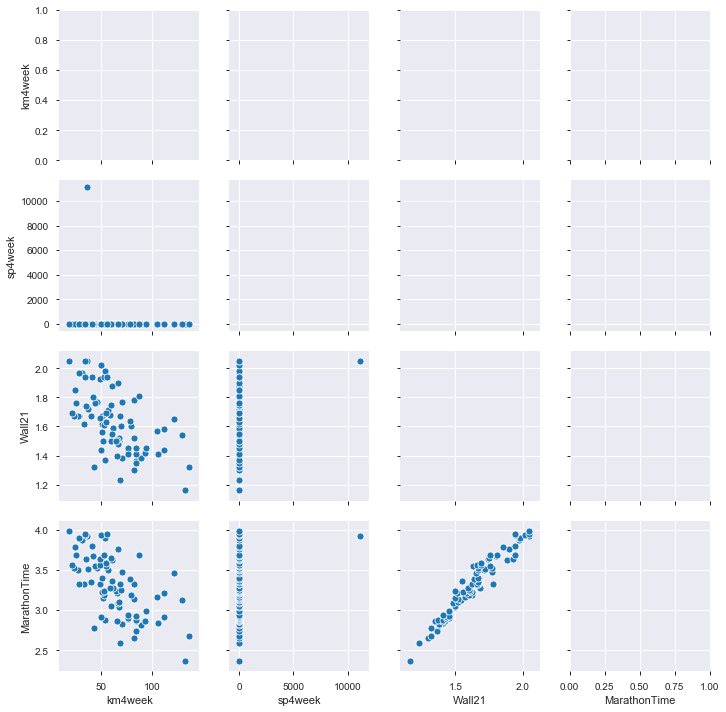

In [37]:
g = sns.PairGrid(datos_maraton[['km4week','sp4week','Wall21','MarathonTime']])  #Quiero probar con sns a ver la cuadríacula 

g.map_lower(sns.scatterplot)


Mucha información de golpe, observamos unos puntos aislados en sp4week que nos perturban los gráficos, así pues, procedemos a eliminarlos.

In [38]:
#Empezamos con sp4week, y nos quitamos ese valor >1000
datos_maraton= datos_maraton.query('sp4week<1000')

datos_maraton

,Category,km4week,sp4week,CrossTraining,Wall21,MarathonTime
0,0,132.8,14.434783,0,1.16,2.37
1,0,68.6,13.674419,0,1.23,2.59
2,0,82.7,13.520436,0,1.30,2.66
3,1,137.5,12.258544,0,1.32,2.68
4,0,84.6,13.945055,0,1.36,2.74
...,...,...,...,...,...,...
82,4,50.0,10.830325,0,2.02,3.93
83,2,33.6,10.130653,4,1.94,3.93
84,2,55.4,11.043189,0,1.94,3.94
85,1,33.2,11.066667,0,2.05,3.95


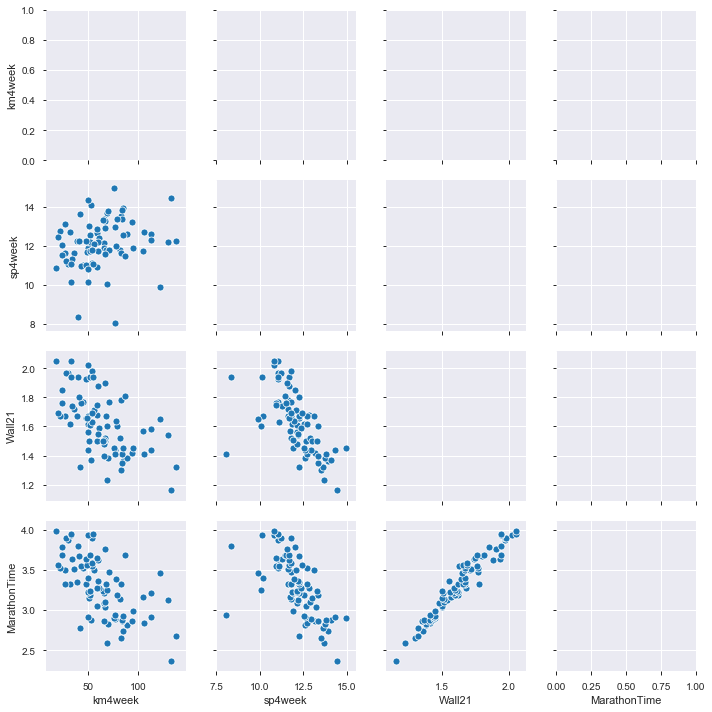

In [39]:
#Volvemso a visualizar a ver qué pasa
g = sns.PairGrid(datos_maraton[['km4week','sp4week','Wall21','MarathonTime']]) 

g.map_lower(sns.scatterplot)

Tendríamos todavía un punto por sp4week que parece que se desvía mucho, se pordría estudiar a parte, pero decidimos eliminarlo también

In [41]:
datos_maraton.sort_values('sp4week', ascending=True)


,Category,km4week,sp4week,CrossTraining,Wall21,MarathonTime
19,0,76.7,8.031414,0,1.41,2.94
76,0,40.3,8.337931,5,1.94,3.80
52,2,121.7,9.907734,0,1.65,3.46
39,5,69.2,10.053269,0,1.60,3.25
83,2,33.6,10.130653,4,1.94,3.93
...,...,...,...,...,...,...
4,0,84.6,13.945055,0,1.36,2.74
12,1,53.5,14.078947,2,1.37,2.88
17,2,49.7,14.336538,0,1.44,2.91
0,0,132.8,14.434783,0,1.16,2.37


In [42]:
#Elimino ese datos que no me termina de convencer
datos_maraton=datos_maraton.drop(19, axis=0)
datos_maraton=datos_maraton.reset_index()
datos_maraton

,index,Category,km4week,sp4week,CrossTraining,Wall21,MarathonTime
0,0,0,132.8,14.434783,0,1.16,2.37
1,1,0,68.6,13.674419,0,1.23,2.59
2,2,0,82.7,13.520436,0,1.30,2.66
3,3,1,137.5,12.258544,0,1.32,2.68
4,4,0,84.6,13.945055,0,1.36,2.74
...,...,...,...,...,...,...,...
74,82,4,50.0,10.830325,0,2.02,3.93
75,83,2,33.6,10.130653,4,1.94,3.93
76,84,2,55.4,11.043189,0,1.94,3.94
77,85,1,33.2,11.066667,0,2.05,3.95


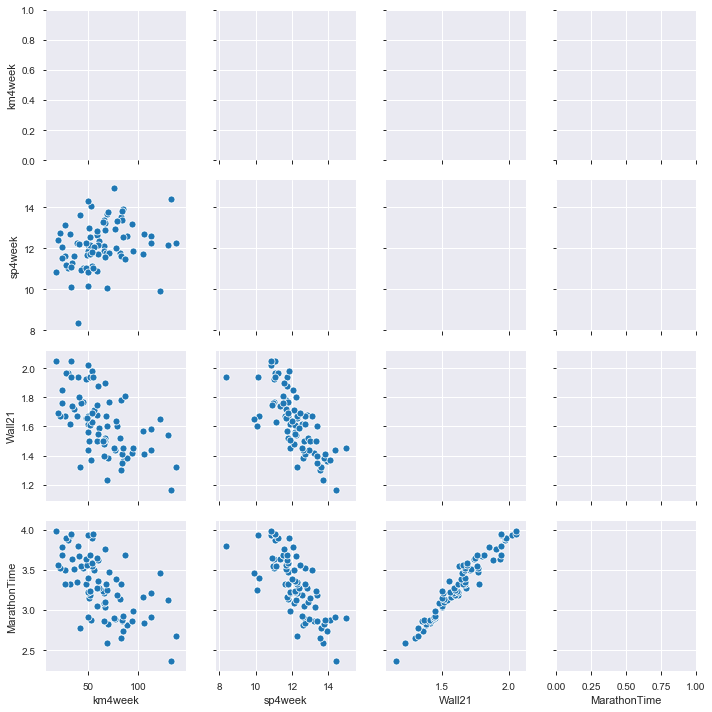

In [43]:
g = sns.PairGrid(datos_maraton[['km4week','sp4week','Wall21','MarathonTime']])  

g.map_lower(sns.scatterplot)


Ahora sí tendríamos nuestros datos listos para poder meterlos en una red neuronal, falta la categoria y el cross training

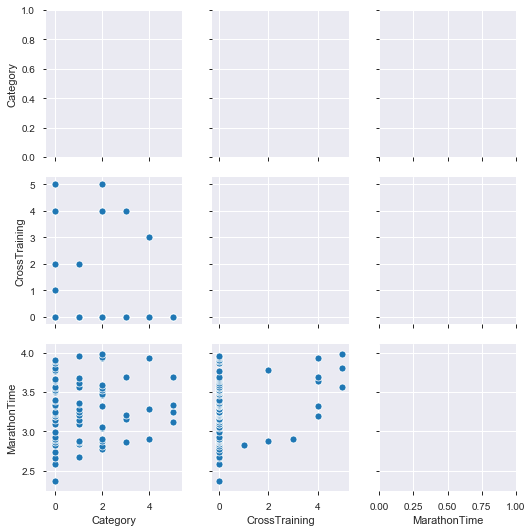

In [44]:
g = sns.PairGrid(datos_maraton[['Category','CrossTraining','MarathonTime']])  

g.map_lower(sns.scatterplot)

Podemos observar que con CrossTraining se obtienen mejores resultados, pero debido a la gran cantidad de missings no lo tendremos en cuenta para el modelo.

## 8. Modelización

Como simempre, tenemos ahora que preparar los datos de train y test. Recordamos que nuestro objetivo es predecir el tiempo que harán atletas con diferentes preparaciones y registros.

In [45]:
from sklearn.model_selection import train_test_split #ValidacionEx
from sklearn import linear_model
from sklearn.metrics import r2_score


In [46]:
X= datos_maraton.iloc[:,1:6]         #Input
Y= datos_maraton.MarathonTime        #Output

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size= 0.25, random_state= 10)

regr=linear_model.LinearRegression()
regr.fit(x_train, y_train)
predicciones=regr.predict(x_test)
print('R2', r2_score(y_test, predicciones))



R2 0.9194458625190032


Acabamos de realizar un siple train//test, probemos ahora con k-fold

In [47]:
from sklearn.model_selection import KFold

datos_maraton=datos_maraton.reset_index()

kf= KFold(n_splits= 10, shuffle= True) #Lo de shuffle es para que no vaya en orden

kf.get_n_splits(X)

regr= linear_model.LinearRegression()

resultados=[]

for train_index, test_index in kf.split(X):

	x_train, x_test = X.loc[train_index,], X.loc[test_index,]
	y_train, y_test= Y[train_index], Y[test_index]
	regr.fit(x_train, y_train)
	predicciones= regr.predict(x_test)
	print('R2', r2_score(y_test, predicciones))
	resultados.append(r2_score(y_test,predicciones))

print('R2 medio:', np.mean(resultados))

R2 0.8659405148702616
R2 0.8692291335944454
R2 0.9724542244402081
R2 0.8662782108177287
R2 0.876074884133595
R2 0.936656023491168
R2 0.8856965776441685
R2 0.9817877679539591
R2 0.9598532558976606
R2 0.9617301319998697
R2 medio: 0.9175700724843064


Con este método ahora sí que sí podemos estar mucho más seguros de que nuestros resultados son convenientes. Y con esto ya estaría hecho el modelo. Solo resta hacer la llamada de ''regr.predict(x_test)'' con los parámetros necesarios. (Category,	km4week,	sp4week,	CrossTraining,	Wall21)